# Linear Approximation of f(x) = log(1 + x)




In [1]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

## a) Generate Random Data and Labels

We generate $N = 10{,}000$ random numbers from the interval $[0, 2]$:

$$
x_1, x_2, \dots, x_N \in [0, 2]
$$

For each generated $x_i$, we compute the corresponding label:

$$
y_i = \log(1 + x_i), \quad i = 1, 2, \dots, N
$$

This gives us our dataset $(X, y)$ for performing linear regression.

In [2]:
np.random.seed(42)
N = 10000
X = np.random.uniform(0, 2, N)
y = np.log(1+X)
X = X.reshape(-1,1)

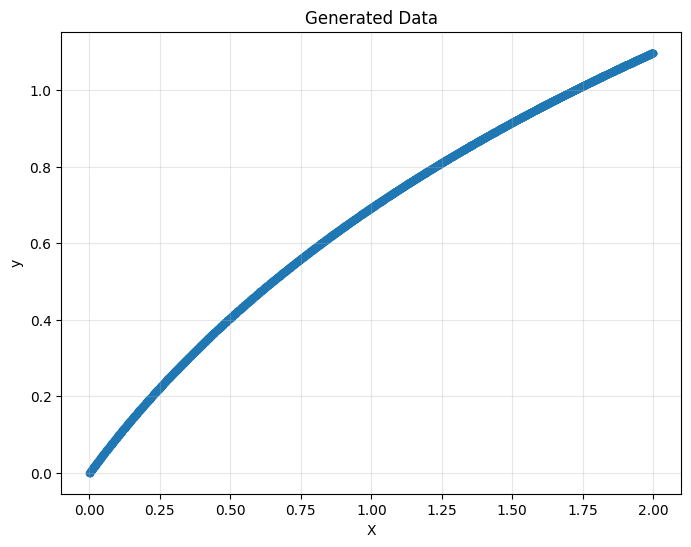

In [3]:


plt.figure(figsize=(8, 6))
plt.scatter(X, y, alpha=0.5, s=20)
plt.xlabel('X')
plt.ylabel('y')
plt.title('Generated Data')
plt.grid(True, alpha=0.3)
plt.show()

# Split data: 70% train, 15% validation, 15% test

In [4]:
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size = 0.15, random_state = 42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size = 0.176, random_state = 42) # 0.176 * 0.85 ≈ 0.15

In [5]:
print(f"Train size: {len(X_train)}")
print(f"Validation size: {len(X_val)}")
print(f"Test size: {len(X_test)}")

Train size: 7004
Validation size: 1496
Test size: 1500


## b) Perform Linear Regression

Perform linear regression on the generated data using the **closed-form solution**:

$$
\theta = (X^T X)^{-1} X^T y
$$

where $X$ is the design matrix and $y$ is the vector of labels.

In [6]:
def closed_form_linear_regression(X_train, y_train):
  X_train_bias = np.hstack([np.ones((X_train.shape[0], 1)), X_train])

  beta = np.linalg.inv(X_train_bias.T @ X_train_bias) @ X_train_bias.T @ y_train

  return beta

def predict_closed_form(X, beta):
  X_bias = np.hstack([np.ones((X.shape[0], 1)), X])

  y_pred = X_bias @ beta

  return y_pred

beta = closed_form_linear_regression(X_train, y_train)
intercept = beta[0]
coefficient = beta[1]

y_pred = predict_closed_form(X_test, beta)

In [7]:
def evaluate_model(y_true, y_pred, dataset_name=""):
  mse = mean_squared_error(y_true, y_pred)
  mae = mean_absolute_error(y_true, y_pred)
  r2 = r2_score(y_true, y_pred)

  metrics = {
        'R²': r2,
        'MSE': mse,
        'MAE': mae
    }

  if dataset_name:
    print(f"\n{dataset_name} Set Evaluation")
  for metric_name, value in metrics.items():
    print(f"{metric_name:6s}: {value:.6f}")

  return metrics

In [8]:
beta = closed_form_linear_regression(X_train, y_train)

y_train_pred = predict_closed_form(X_train, beta)
y_val_pred = predict_closed_form(X_val, beta)
y_test_pred = predict_closed_form(X_test, beta)

train_metrics = evaluate_model(y_train, y_train_pred, "Train")
val_metrics = evaluate_model(y_val, y_val_pred, "Validation")
test_metrics = evaluate_model(y_test, y_test_pred, "Test")

print(f"\nModel Parameters:")
print(f"Intercept: {beta[0]:.6f}")
print(f"Coefficient: {beta[1]:.6f}")



Train Set Evaluation
R²    : 0.980851
MSE   : 0.001822
MAE   : 0.036316

Validation Set Evaluation
R²    : 0.980674
MSE   : 0.001799
MAE   : 0.036502

Test Set Evaluation
R²    : 0.980237
MSE   : 0.001841
MAE   : 0.036586

Model Parameters:
Intercept: 0.118221
Coefficient: 0.529786


## c) Perform Linear Regression using sklearn



In [9]:
model = LinearRegression()
model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)
y_test_pred = model.predict(X_test)



In [10]:
train_metrics = evaluate_model(y_train, y_train_pred, "Train")
val_metrics = evaluate_model(y_val, y_val_pred, "Validation")
test_metrics = evaluate_model(y_test, y_test_pred, "Test")


Train Set Evaluation
R²    : 0.980851
MSE   : 0.001822
MAE   : 0.036316

Validation Set Evaluation
R²    : 0.980674
MSE   : 0.001799
MAE   : 0.036502

Test Set Evaluation
R²    : 0.980237
MSE   : 0.001841
MAE   : 0.036586


In [11]:
print(model.intercept_)
model.coef_

0.11822067476832399


array([0.52978556])

## d) Perform Linear Regression using Gradient Descent

Perform linear regression on the generated data by implementing the **gradient descent algorithm** from scratch.

The gradient descent update rule is:

$$
\theta_{new} = \theta_{old} - \alpha \nabla J(\theta)
$$

where $\alpha$ is the learning rate and $\nabla J(\theta)$ is the gradient of the loss function.

In [45]:
def gradient_descent(x, y, iterations=10000, lr=1e-3,
                     stopping_threshold=1e-6, use_xavier=True,
                     ridge=False, lambda_reg=0.01):

    x = x.flatten()
    n = len(x)

    # Initialization
    if use_xavier:
        current_weight = np.random.randn()
        current_bias = 0.0
    else:
        current_weight = 0.1
        current_bias = 0.01

    costs = []
    # weights = []
    # biases = []
    previous_cost = None

    print(f"Ridge Regularization: {'Enabled' if ridge else 'Disabled'}")
    if ridge:
        print(f"Lambda (λ): {lambda_reg}")

    for i in range(iterations):
        # Forward pass
        y_predicted = current_weight * x + current_bias

        # Calculate cost (MSE)
        error = y - y_predicted
        mse_cost = np.mean(error ** 2)

        # Add regularization term to cost if Ridge is enabled
        if ridge:
            # Ridge cost = MSE + λ * ||w||²
            regularization_cost = lambda_reg * (current_weight ** 2)
            current_cost = mse_cost + regularization_cost
        else:
            current_cost = mse_cost

        # Check convergence
        if previous_cost and abs(previous_cost - current_cost) <= stopping_threshold:
            print(f"Converged at iteration {i+1}")
            break

        previous_cost = current_cost
        costs.append(current_cost)
        # weights.append(current_weight)
        # biases.append(current_bias)

        # Calculate gradients
        weight_derivative = -(2/n) * np.dot(x, error)
        bias_derivative = -(2/n) * np.sum(error)

        # Add regularization gradient if Ridge is enabled
        if ridge:
            # Ridge gradient: add 2λw to weight gradient
            weight_derivative += 2 * lambda_reg * current_weight

        # Update parameters
        current_weight -= lr * weight_derivative
        current_bias -= lr * bias_derivative

        # Print progress
        if (i+1) % 2000 == 0:
            if ridge:
                print(f"Iteration {i+1}: Total Cost {current_cost:.6f}, "
                      f"MSE {mse_cost:.6f}, Reg {regularization_cost:.6f}")
            else:
                print(f"Iteration {i+1}: Cost {current_cost:.6f}")



    return current_weight, current_bias


TRAINING MODELS WITH DIFFERENT REGULARIZATION

Training with λ = 0
Ridge Regularization: Disabled
Converged at iteration 1134

Training with λ = 0.001
Ridge Regularization: Enabled
Lambda (λ): 0.001
Converged at iteration 937

Training with λ = 0.01
Ridge Regularization: Enabled
Lambda (λ): 0.01
Converged at iteration 831

Training with λ = 0.1
Ridge Regularization: Enabled
Lambda (λ): 0.1
Converged at iteration 637

Training with λ = 0.5
Ridge Regularization: Enabled
Lambda (λ): 0.5
Converged at iteration 428

Training with λ = 1.0
Ridge Regularization: Enabled
Lambda (λ): 1.0
Converged at iteration 400

CREATING VISUALIZATIONS


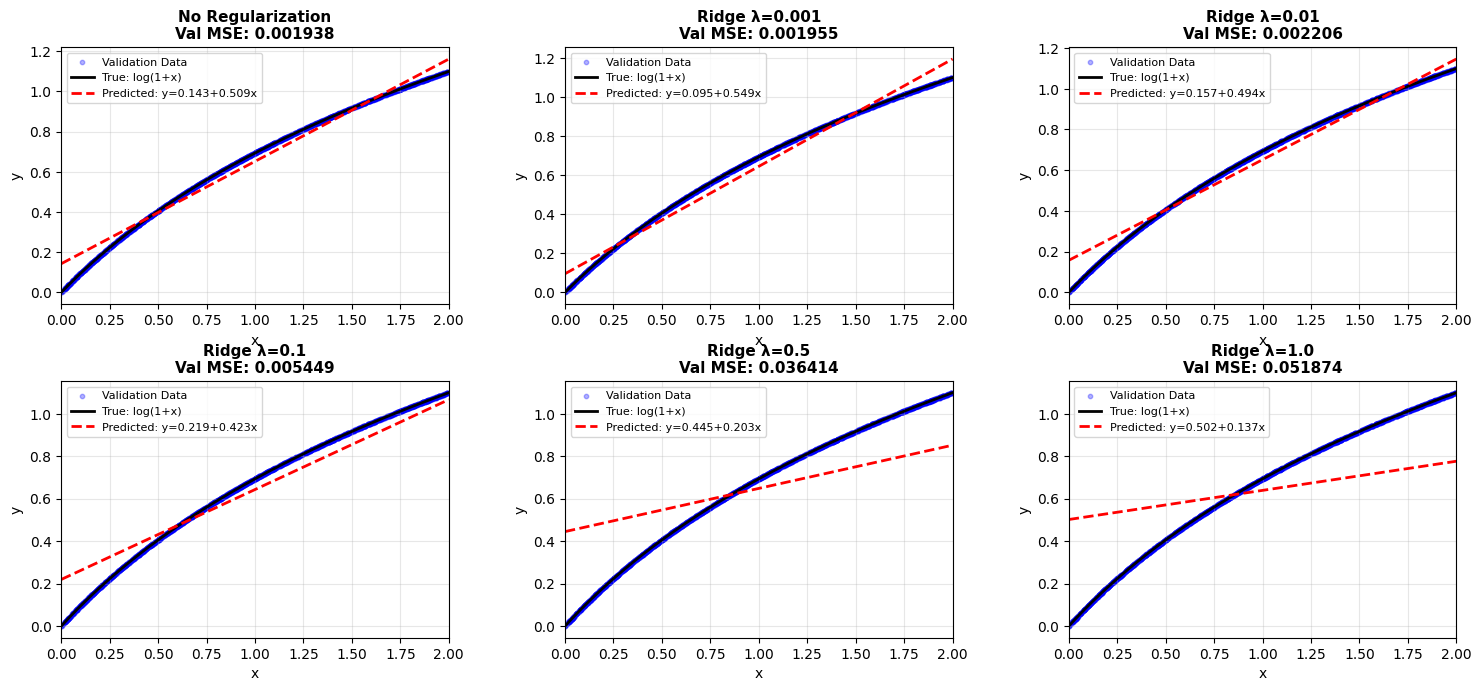


SUMMARY TABLE
Lambda             Weight         Bias    Train MSE      Val MSE     Test MSE
--------------------------------------------------------------------------------
No Ridge         0.508806     0.142724   0.00198238   0.00193839   0.00196257
0.001            0.549106     0.095356   0.00196015   0.00195503   0.00200781
0.01             0.493971     0.157382   0.00226253   0.00220595   0.00221678
0.1              0.423372     0.219463   0.00560138   0.00544950   0.00543745
0.5              0.203376     0.444731   0.03726024   0.03641363   0.03631677
1.0              0.137179     0.501633   0.05308641   0.05187447   0.05193326

Best lambda based on validation MSE: λ = 0.001
Best validation MSE: 0.00195891


In [29]:
# Train models with different lambda values
lambdas = [0, 0.001, 0.01, 0.1, 0.5, 1.0]
results = {}

print("\n" + "="*80)
print("TRAINING MODELS WITH DIFFERENT REGULARIZATION")
print("="*80)

for lam in lambdas:
    # print(f"\nTraining with λ = {lam}")

    if lam == 0:
        # No regularization
        weight, bias = gradient_descent(
            X_train, y_train,
            iterations=10000,
            lr=0.01,
            ridge=False
        )
    else:
        # With Ridge regularization
        weight, bias = gradient_descent(
            X_train, y_train,
            iterations=10000,
            lr=0.01,
            ridge=True,
            lambda_reg=lam
        )

    # Predictions on all sets
    y_train_pred = weight * X_train + bias
    y_val_pred = weight * X_val + bias
    y_test_pred = weight * X_test + bias

    # Calculate MSE for all sets
    train_mse = mean_squared_error(y_train, y_train_pred)
    val_mse = mean_squared_error(y_val, y_val_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)

    results[lam] = {
        'weight': weight,
        'bias': bias,
        'train_mse': train_mse,
        'val_mse': val_mse,
        'test_mse': test_mse
    }

    # print(f"Weight: {weight:.6f}, Bias: {bias:.6f}")
    # print(f"Train MSE: {train_mse:.6f}, Val MSE: {val_mse:.6f}, Test MSE: {test_mse:.6f}")


# Visualization
print("\n" + "="*80)
print("CREATING VISUALIZATIONS")
print("="*80)

fig = plt.figure(figsize=(18, 12))

# Create grid for subplots
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# Plot 1-6: Individual models on validation data
for idx, lam in enumerate(lambdas):
    row = idx // 3
    col = idx % 3
    ax = fig.add_subplot(gs[row, col])

    weight = results[lam]['weight']
    bias = results[lam]['bias']
    val_mse = results[lam]['val_mse']

    # Plot validation data
    ax.scatter(X_val, y_val, alpha=0.3, s=10, color='blue', label='Validation Data')

    # Plot true function
    x_plot = np.linspace(0, 2, 1000)
    y_true = np.log(1 + x_plot)
    ax.plot(x_plot, y_true, 'k-', linewidth=2, label='True: log(1+x)')

    # Plot predicted line
    y_pred_line = weight * x_plot + bias
    ax.plot(x_plot, y_pred_line, 'r--', linewidth=2,
            label=f'Predicted: y={bias:.3f}+{weight:.3f}x')

    ax.set_xlabel('x', fontsize=10)
    ax.set_ylabel('y', fontsize=10)

    if lam == 0:
        ax.set_title(f'No Regularization\nVal MSE: {val_mse:.6f}',
                     fontsize=11, fontweight='bold')
    else:
        ax.set_title(f'Ridge λ={lam}\nVal MSE: {val_mse:.6f}',
                     fontsize=11, fontweight='bold')

    ax.legend(fontsize=8, loc='upper left')
    ax.grid(True, alpha=0.3)
    ax.set_xlim([0, 2])

plt.savefig('ridge_comparison_grid.png', dpi=150, bbox_inches='tight')
plt.show()



# Summary table
print("\n" + "="*80)
print("SUMMARY TABLE")
print("="*80)
print(f"{'Lambda':<12} {'Weight':>12} {'Bias':>12} {'Train MSE':>12} {'Val MSE':>12} {'Test MSE':>12}")
print("-"*80)
for lam in lambdas:
    weight = results[lam]['weight']
    bias = results[lam]['bias']
    train_mse = results[lam]['train_mse']
    val_mse = results[lam]['val_mse']
    test_mse = results[lam]['test_mse']

    lam_str = 'No Ridge' if lam == 0 else f'{lam}'
    print(f"{lam_str:<12} {weight:>12.6f} {bias:>12.6f} {train_mse:>12.8f} {val_mse:>12.8f} {test_mse:>12.8f}")
print("="*80)

print(f"\nBest lambda based on validation MSE: λ = {best_lam}")
print(f"Best validation MSE: {best_val_mse:.8f}")

## f*) Perform Linear Regression using PyTorch



In [32]:
import torch
import torch.nn as nn
import torch.optim as optim


X_torch = torch.FloatTensor(X_train)
y_torch = torch.FloatTensor(y_train.reshape(-1,1)) # Corrected reshaped to reshape

class LinearRegressionModel(nn.Module):
  def __init__(self):
    super(LinearRegressionModel, self).__init__()
    self.linear = nn.Linear(1,1)

  def forward(self, x):
    return self.linear(x) # Corrected Linear to linear

model_pytorch = LinearRegressionModel()
criterion = nn.MSELoss()
optimizer = optim.SGD(model_pytorch.parameters(), lr = 0.01) # Corrected model_pythorch to model_pytorch

epochs = 5000
for epoch in range(epochs):
  #Forward
  y_pred_torch = model_pytorch(X_torch)
  loss = criterion(y_pred_torch, y_torch)

  #Backward

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  if (epoch + 1) % 1000 == 0:
    print(f"Epoch {epoch +1}: Loss = {loss.item()}")

weight_pytorch = model_pytorch.linear.weight.item()
bias_pytorch = model_pytorch.linear.bias.item()
y_pred_pytorch = model_pytorch(X_torch).detach().numpy().flatten()
mse_pytorch = mean_squared_error(y_train, y_pred_pytorch) # Using y_train for MSE calculation

print(f"\nFinal Weight: {weight_pytorch:.6f}")
print(f"Final Bias: {bias_pytorch:.6f}")
print(f"Final MSE: {mse_pytorch:.6f}")

Epoch 1000: Loss = 0.001914975349791348
Epoch 2000: Loss = 0.0018219344783574343
Epoch 3000: Loss = 0.0018217432079836726
Epoch 4000: Loss = 0.0018217432079836726
Epoch 5000: Loss = 0.0018217432079836726

Final Weight: 0.529781
Final Bias: 0.118226
Final MSE: 0.001822


## g) Perform Linear Regression using Mini-Batch Gradient Descent


In [48]:
def mini_batch_gradient_descent(x, y, batch_size=32, epochs=100, lr=0.01, use_xavier=False):
    x = x.flatten()
    n = len(x)

    # Initialization
    if use_xavier:
        # Xavier initialization (for 1D case, just random normal scaled)
        current_weight = np.random.randn()
        current_bias = 0.0
    else:
        current_weight = 0.1
        current_bias = 0.01

    costs = []

    for epoch in range(epochs):
        indices = np.random.permutation(n)
        x_shuffled = x[indices]
        y_shuffled = y[indices]

        for i in range(0, n, batch_size):
            x_batch = x_shuffled[i:i+batch_size]
            y_batch = y_shuffled[i:i+batch_size]
            batch_n = len(x_batch)

            # Forward pass
            y_pred = current_weight * x_batch + current_bias

            # Gradients
            error = y_batch - y_pred
            weight_grad = -(2/batch_n) * np.dot(x_batch, error)
            bias_grad = -(2/batch_n) * np.sum(error)

            # Update
            current_weight -= lr * weight_grad
            current_bias -= lr * bias_grad

        # Track cost
        y_pred_full = current_weight * x + current_bias
        cost = np.mean((y - y_pred_full) ** 2)
        costs.append(cost)

        if (epoch + 1) % 20 == 0:
            print(f"Epoch {epoch+1}: Cost = {cost:.6f}")

    return current_weight, current_bias


In [50]:
w, b = mini_batch_gradient_descent(X_train, y_train,use_xavier=True)
print(w, b)

Epoch 20: Cost = 0.001830
Epoch 40: Cost = 0.001822
Epoch 60: Cost = 0.001822
Epoch 80: Cost = 0.001822
Epoch 100: Cost = 0.001822
0.5291925631111287 0.11801066129586875


## h) Visualize All Approximations

Plot all the linear regression approximations on a single graph for comparison:

- Closed-form solution
- sklearn implementation
- Gradient descent (custom implementation)
- PyTorch implementation
- Mini-batch gradient descent (custom implementation)
- Taylor approximation

Compare the results against the true function $y = \log(1 + x)$.


(h) PLOTTING ALL APPROXIMATIONS IN SUBPLOTS
--------------------------------------------------------------------------------


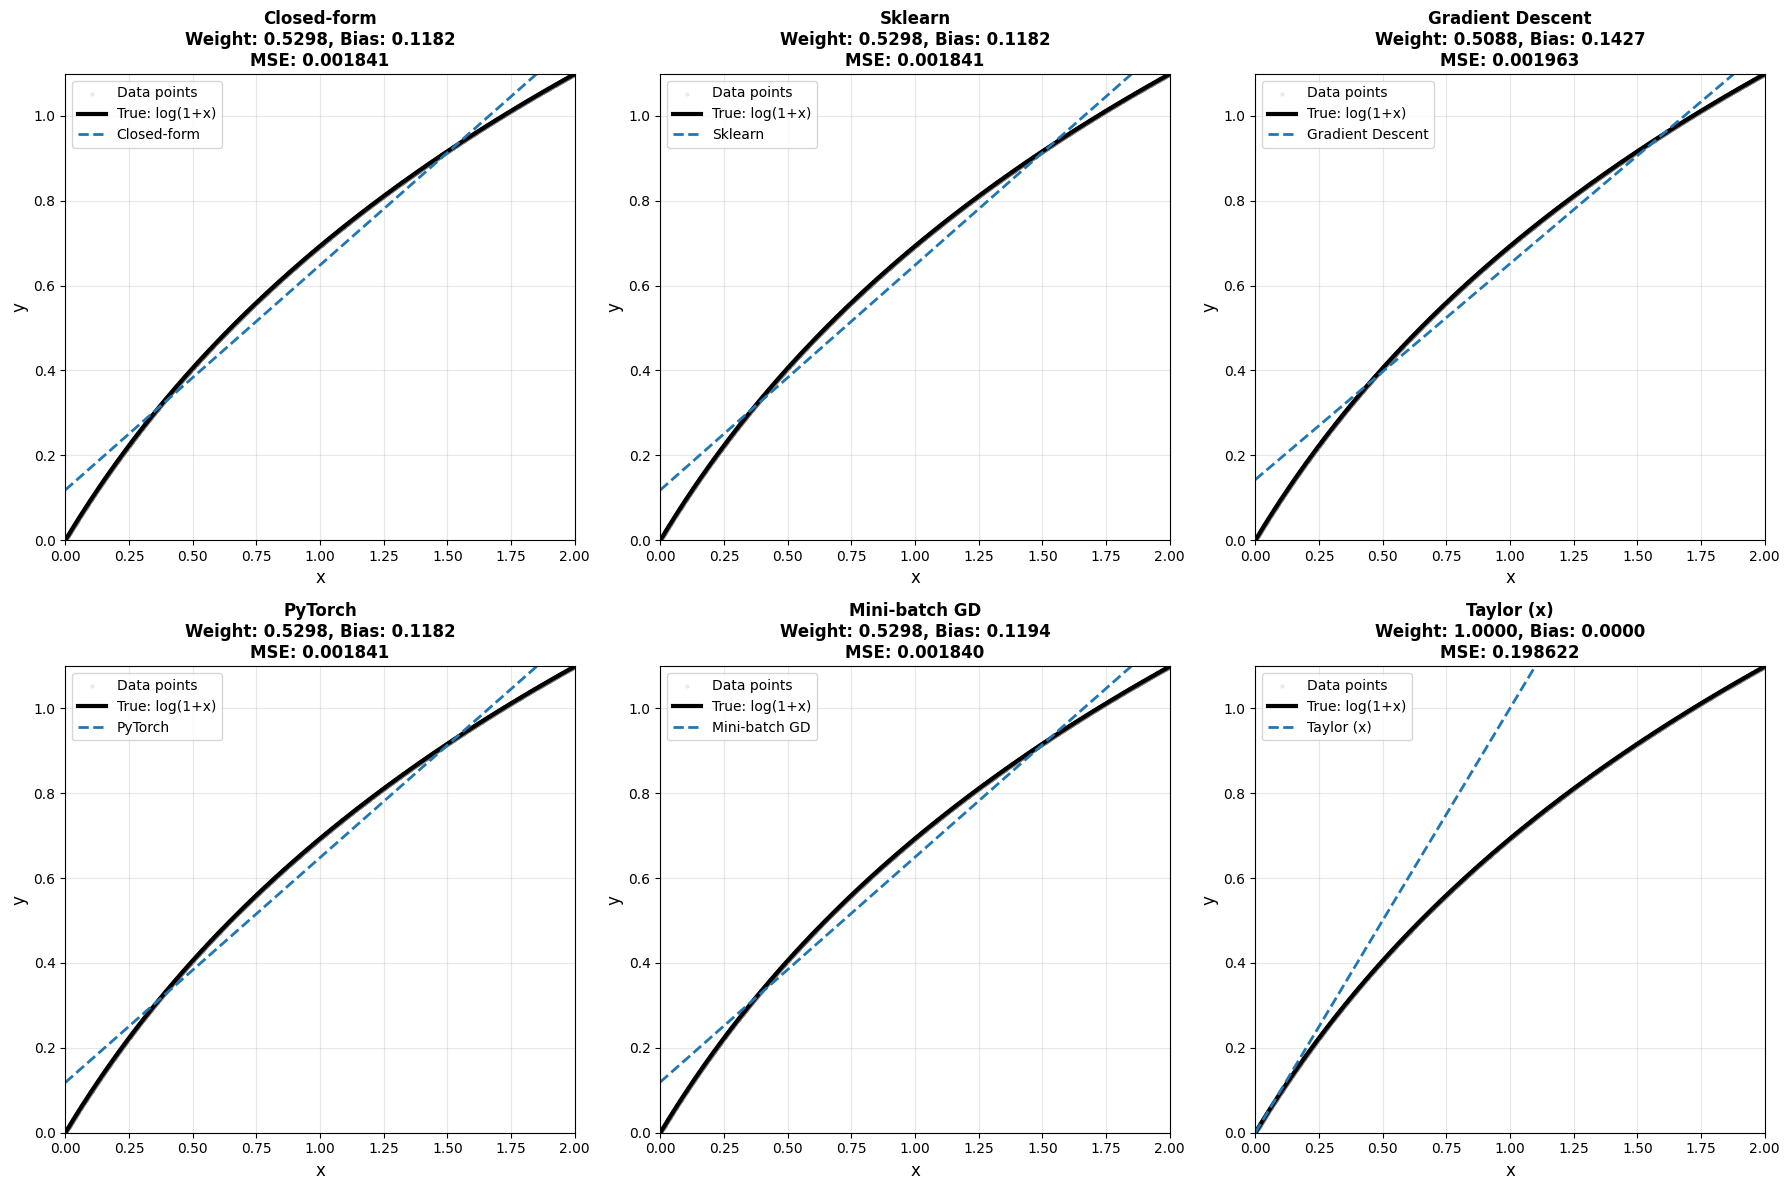

In [54]:
print("\n(h) PLOTTING ALL APPROXIMATIONS IN SUBPLOTS")
print("-"*80)

# Define variables from previous calculations
weight_closed = coefficient
bias_closed = intercept
mse_closed = test_metrics['MSE']

weight_sklearn = model.coef_[0]
bias_sklearn = model.intercept_
mse_sklearn = test_metrics['MSE']

weight_gd = results[0]['weight']
bias_gd = results[0]['bias']
mse_gd = results[0]['test_mse']

weight_pytorch = model_pytorch.linear.weight.item()
bias_pytorch = model_pytorch.linear.bias.item()
# Calculate MSE for PyTorch on test set
y_pred_pytorch_test = model_pytorch(torch.FloatTensor(X_test)).detach().numpy().flatten()
mse_pytorch = mean_squared_error(y_test, y_pred_pytorch_test)

weight_mbgd = weight_mbgd
bias_mbgd = bias_mbgd
# Calculate MSE for mini-batch GD on test set
y_pred_mbgd_test = weight_mbgd * X_test + bias_mbgd
mse_mbgd = mean_squared_error(y_test, y_pred_mbgd_test)


# Taylor approximation of log(1+x) around x=0 is x
weight_taylor = 1.0
bias_taylor = 0.0
# Calculate MSE for Taylor approximation on test set
y_pred_taylor = weight_taylor * X_test + bias_taylor
mse_taylor = mean_squared_error(y_test, y_pred_taylor)


# Create fine grid for smooth curves
x_plot = np.linspace(0, 2, 1000)
y_true = np.log(1 + x_plot)

# Define the approximations and their names
approximations = {
    'Closed-form': (weight_closed, bias_closed, mse_closed),
    'Sklearn': (weight_sklearn, bias_sklearn, mse_sklearn),
    'Gradient Descent': (weight_gd, bias_gd, mse_gd),
    'PyTorch': (weight_pytorch, bias_pytorch, mse_pytorch),
    'Mini-batch GD': (weight_mbgd, bias_mbgd, mse_mbgd),
    'Taylor (x)': (weight_taylor, bias_taylor, mse_taylor)
}

n_approximations = len(approximations)
n_cols = 3
n_rows = (n_approximations + n_cols - 1) // n_cols # Calculate number of rows needed

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, n_rows * 6))
axes = axes.flatten() # Flatten the 2D array of axes for easy iteration

for i, (name, (weight, bias, mse)) in enumerate(approximations.items()):
    ax = axes[i]

    # Plot data points
    ax.scatter(X, y, alpha=0.1, s=5, color='gray', label='Data points')

    # Plot true function
    ax.plot(x_plot, y_true, 'k-', linewidth=3, label='True: log(1+x)')

    # Plot approximation line
    y_pred_line = weight * x_plot + bias
    ax.plot(x_plot, y_pred_line, '--', linewidth=2, label=f'{name}')

    ax.set_xlabel('x', fontsize=12)
    ax.set_ylabel('y', fontsize=12)
    ax.set_title(f'{name}\nWeight: {weight:.4f}, Bias: {bias:.4f}\nMSE: {mse:.6f}', fontsize=12, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)
    ax.set_xlim([0, 2]) # Ensure consistent x-axis limits
    ax.set_ylim([0, np.log(1+2)]) # Ensure consistent y-axis limits


# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])


plt.tight_layout()
plt.show()